# Notebook for removing biological doublets from dataset using `Scrublet`

**Created by :** Srivalli Kolla

**Created on :** 17 May, 2025

**Modified on :** 17 May, 2025

**University of Würzburg**

Env : scanpy (Python 3.12.2)

# Importing Packages

In [28]:
import scanpy as sc
import pandas as pd
import datetime
import os
import scrublet as scr
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [29]:
sc.settings.verbosity = 3
sc.logging.print_versions()

plt.rcParams['figure.dpi'] = 300  
plt.rcParams['savefig.dpi'] = 300

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.11.3
scanpy      1.10.4
-----
Cython                      3.0.12
PIL                         11.1.0
annoy                       NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
certifi                     2025.01.31
charset_normalizer          3.4.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython                      3.0.12
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.13.0
idna                        3.10
igraph                      0.11.8
ipykernel                   6.29.5
ipywidgets                  8

/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


# Data import

In [30]:
cd './Github/Nuclear_hashing_Mag_beads_2025'

[Errno 2] No such file or directory: './Github/Nuclear_hashing_Mag_beads_2025'
/home/gruengroup/srivalli/Github/Nuclear_hashing_Mag_beads_2025


In [31]:
adata = sc.read_h5ad('./data/demultiplexed_htodemux_raw_qc_checked_magnetic_beads_17_05_25.h5ad')
adata

AnnData object with n_obs × n_vars = 7951 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'ident', 'Sample_given', 'Sample-ID', 'Mouse-ID', 'Sex', 'Group', 'Nuclei Purification Method after Hashing', 'assigned_hashtag', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'assigned_hashtag_colors'
    layers: 'logcounts', 'raw_counts'

#### Check if data is raw or Normalized

In [32]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [33]:
print(X_is_raw(adata))

True


# Normalization

In [34]:
sc.pp.normalize_total(adata, target_sum = 1e6)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [35]:
print(X_is_raw(adata))

False


In [36]:
adata.layers['cpm_normalization'] = adata.X

## Doublet score prediction

#### Steps followed

Make a loop to work on all the samples

1. List of samples
2. Subsetting samples based on sample_name
3. Doublet score calculation
4. Assign doublet scores to the sample
5. Plotting

In [37]:
assigned_hashtag_names = adata.obs['assigned_hashtag'].unique()

for assigned_hashtag_name in assigned_hashtag_names:
    mask = adata.obs['assigned_hashtag'] == assigned_hashtag_name
    assigned_hashtag_adata = adata[mask].copy()

    scrub = scr.Scrublet(assigned_hashtag_adata.X)

    assigned_hashtag_adata.obs['doublet_scores'], assigned_hashtag_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = assigned_hashtag_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = assigned_hashtag_adata.obs['predicted_doublets']

    #scrub.plot_histogram()

    #plt.show()

Preprocessing...


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.4%
Elapsed time: 3.1 seconds
Preprocessing...


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 15.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 0.7 seconds
Preprocessing...


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 5.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 9.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.1%
Elapsed time: 0.5 seconds


### Checking the count and percentage of Doublets to choose cutoff

Text(0.5, 1.0, 'Doublets counts and percentage')

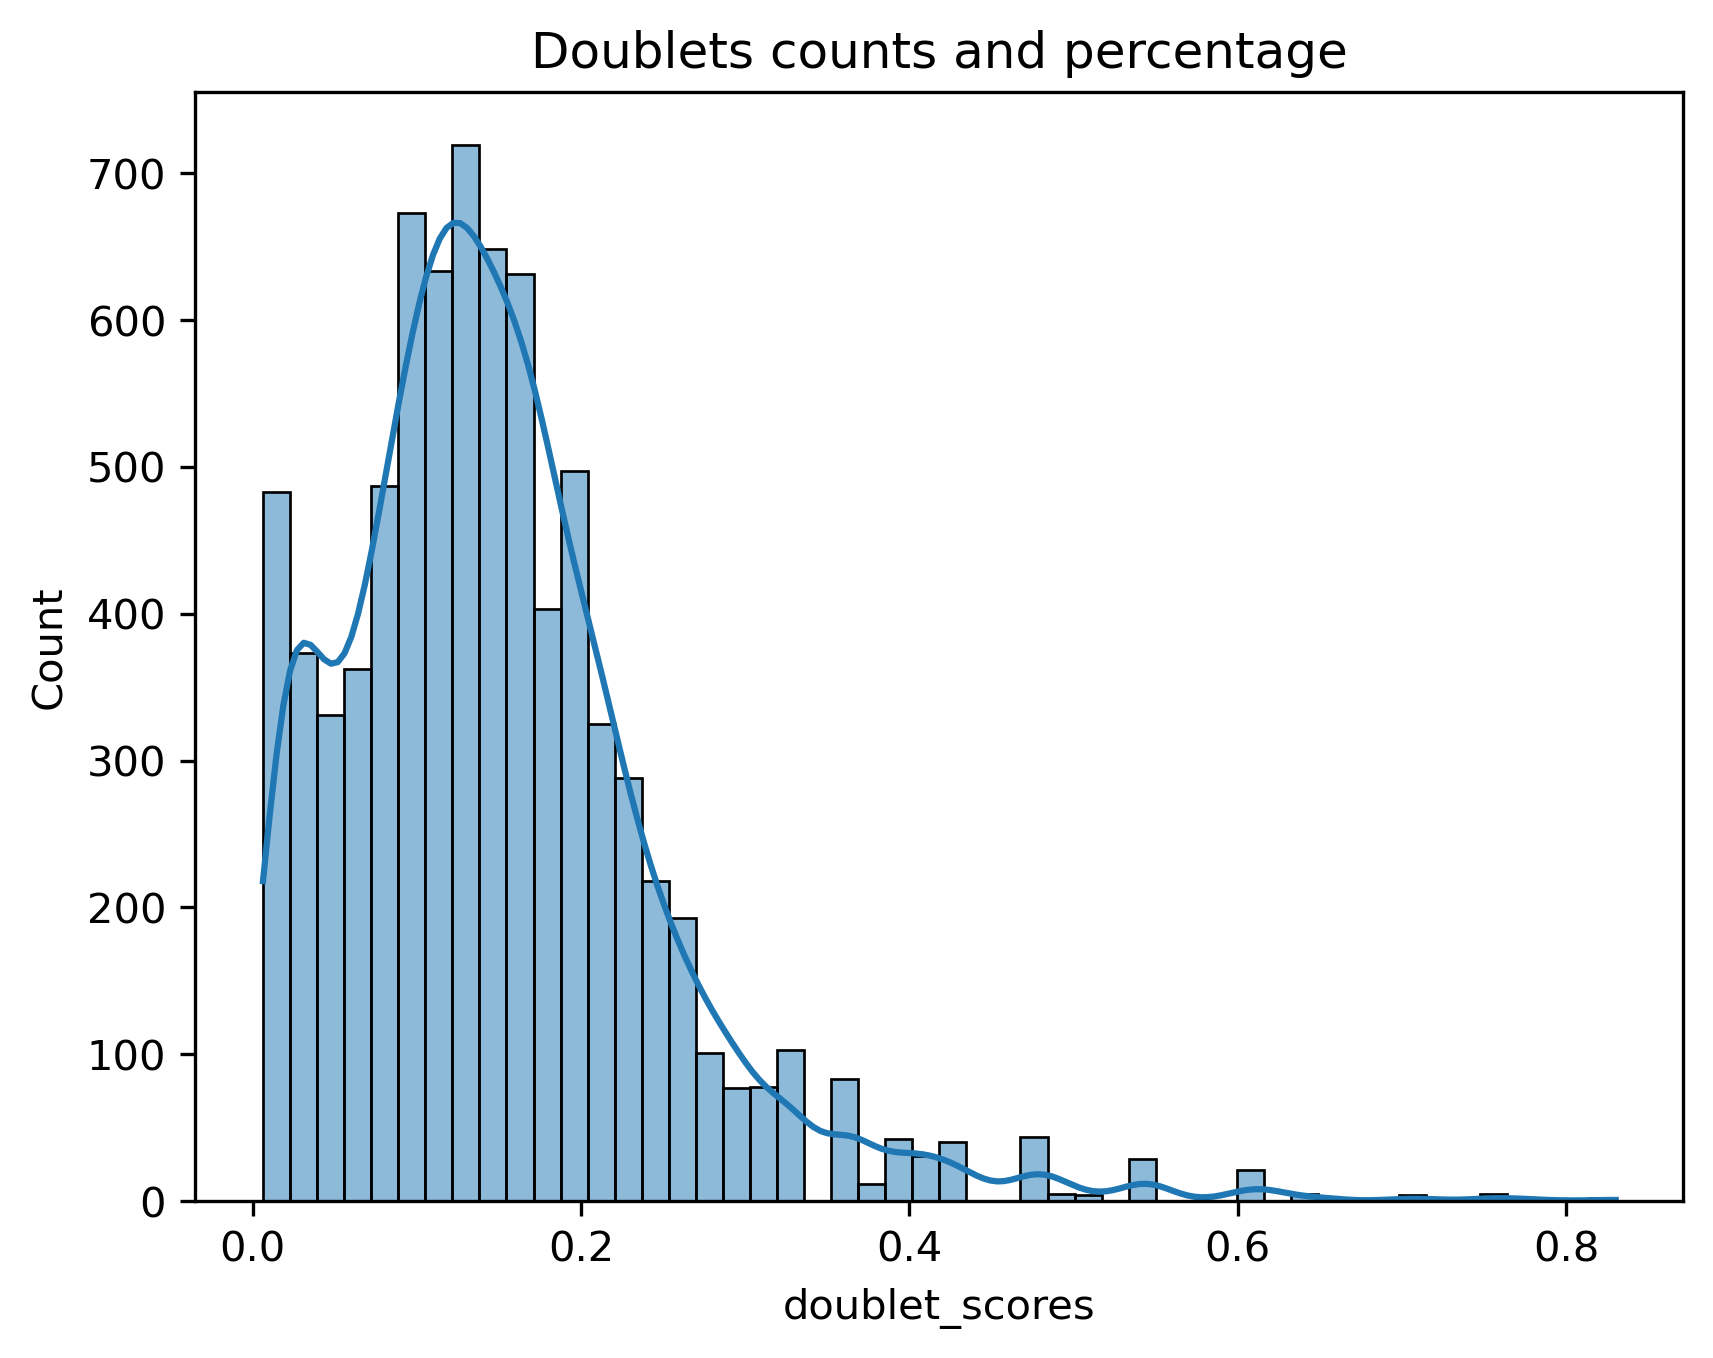

In [38]:
sb.histplot(adata.obs['doublet_scores'], bins=50, kde=True)
plt.title('Doublets counts and percentage')

### Checking the count and percentage of Doublets - Anndata level

In [39]:
doub_tab = pd.crosstab(adata.obs['assigned_hashtag'],adata.obs['predicted_doublets'])
doub_tab.sum()

predicted_doublets
False    7927
True       24
dtype: int64

# Comparision of Biological doublets and Hashtag doublets

### Checking the count of Doublets - Broad level

In [40]:
doublet_counts_per_assigned_hashtag = adata.obs.groupby(['assigned_hashtag'])['predicted_doublets'].sum().reset_index()
doublet_counts_per_assigned_hashtag.rename(columns={'predicted_doublets': 'Doublet_Count'}, inplace=True)
print(doublet_counts_per_assigned_hashtag)

  assigned_hashtag Doublet_Count
0    MCMV_MB_Hash3             7
1    MCMV_MB_Hash4             6
2  Noninf_MB_Hash5             6
3  Noninf_MB_Hash7             5


/tmp/ipykernel_949342/2682781798.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_counts_per_assigned_hashtag = adata.obs.groupby(['assigned_hashtag'])['predicted_doublets'].sum().reset_index()


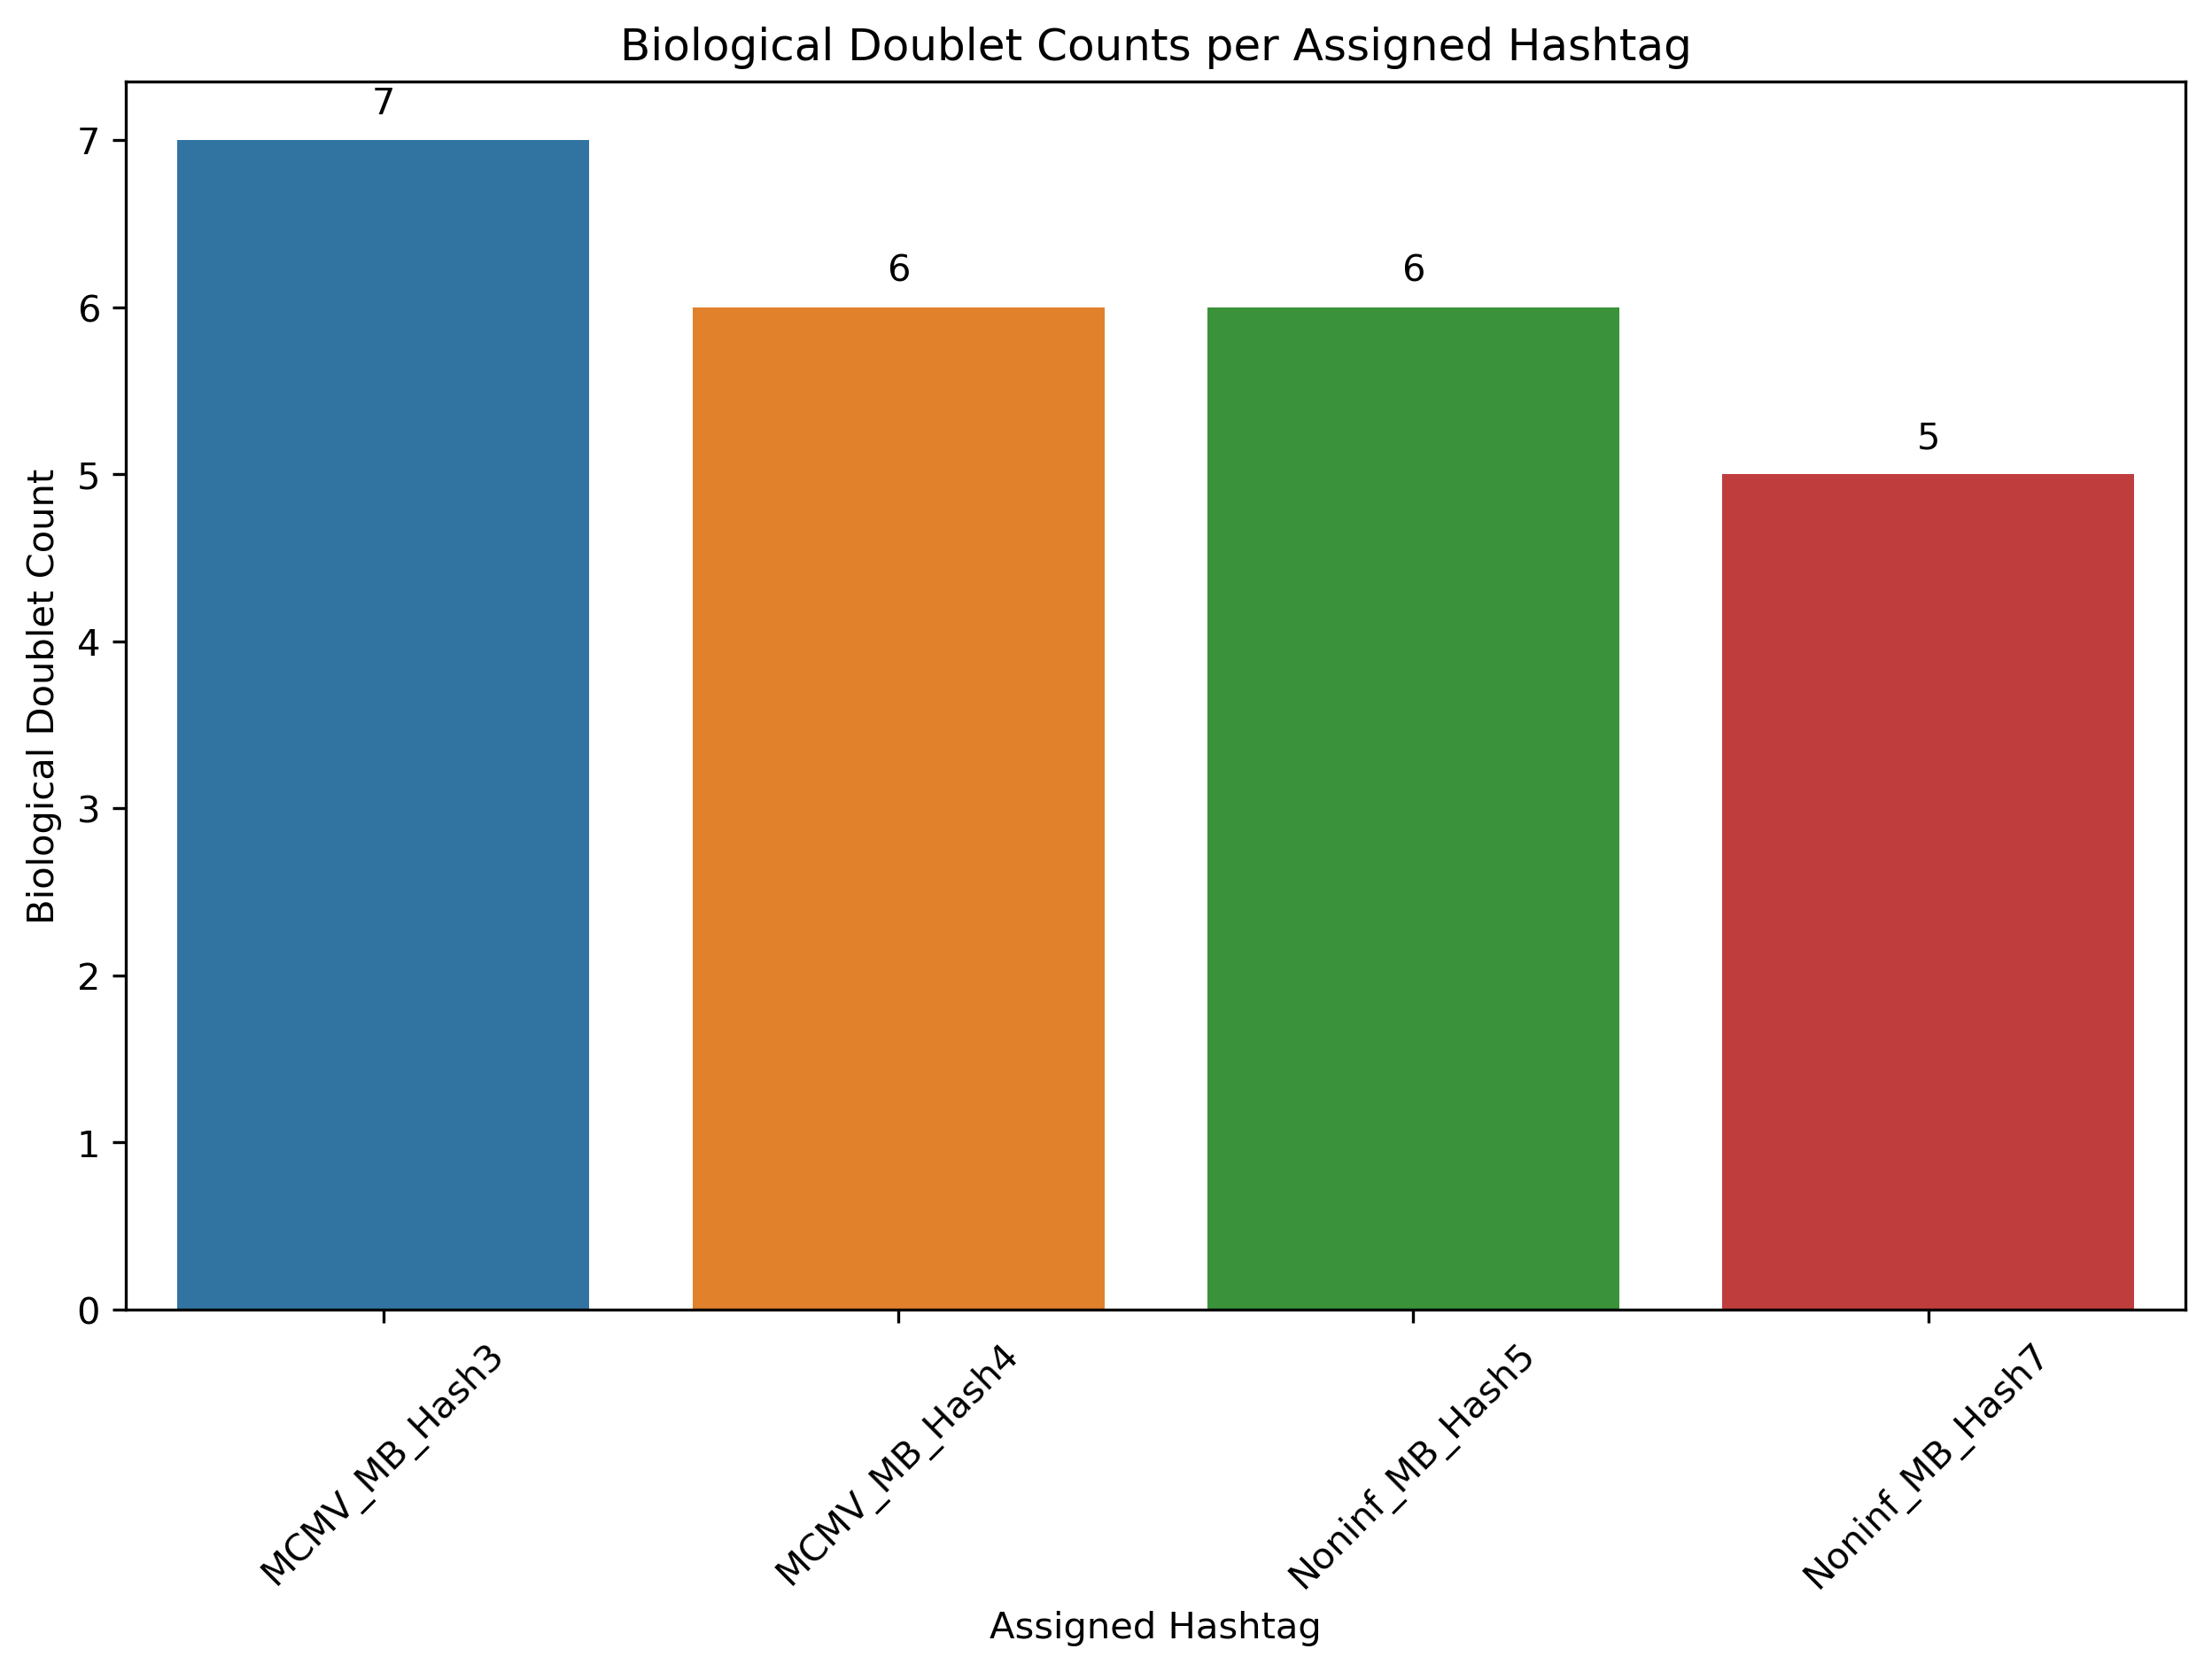

In [41]:
plt.figure(figsize=(10, 6))

ax = sb.barplot(data=doublet_counts_per_assigned_hashtag, x='assigned_hashtag', y='Doublet_Count', hue='assigned_hashtag')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)
plt.xlabel("Assigned Hashtag")
plt.ylabel("Biological Doublet Count")
plt.title("Biological Doublet Counts per Assigned Hashtag")
plt.show()

# Removal of biological doublets having Doublet score > 0.2

In [42]:
filtered_object = adata[adata.obs['doublet_scores'] < 0.2].copy()
filtered_object

AnnData object with n_obs × n_vars = 6029 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'ident', 'Sample_given', 'Sample-ID', 'Mouse-ID', 'Sex', 'Group', 'Nuclei Purification Method after Hashing', 'assigned_hashtag', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'assigned_hashtag_colors', 'log1p'
    layers: 'logcounts', 'raw_counts', 'cpm_normalization'

Text(0.5, 1.0, 'Doublets counts and percentage')

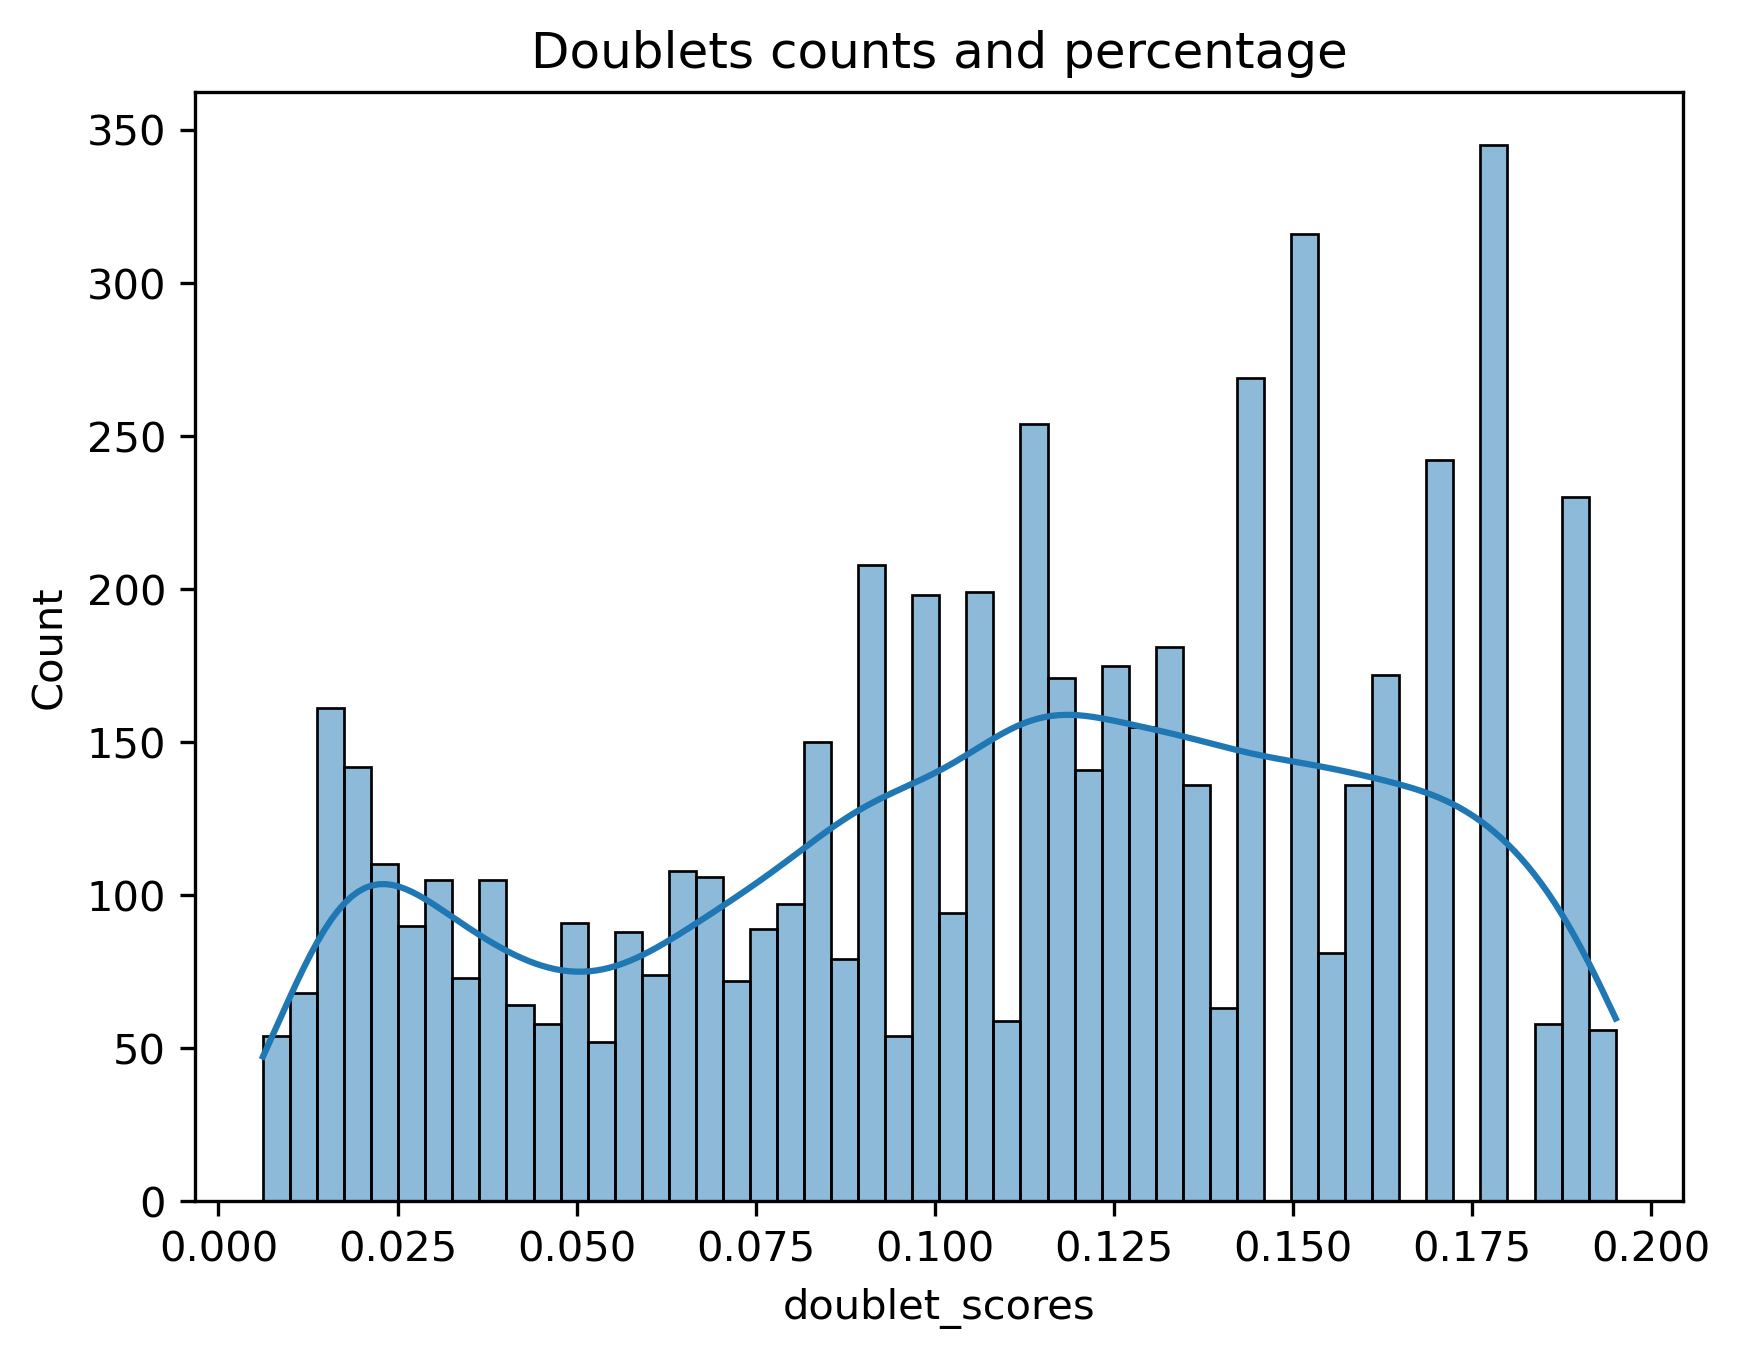

In [43]:
sb.histplot(filtered_object.obs['doublet_scores'], bins=50, kde=True)
plt.title('Doublets counts and percentage')

### Checking the count of Doublets - Global level

In [44]:
doublet_counts_per_assigned_hashtag_global =filtered_object.obs.groupby(['assigned_hashtag'])['predicted_doublets'].sum().reset_index()
doublet_counts_per_assigned_hashtag_global.rename(columns={'predicted_doublets': 'Doublet_Count'}, inplace=True)
print(doublet_counts_per_assigned_hashtag_global)

  assigned_hashtag Doublet_Count
0    MCMV_MB_Hash3             0
1    MCMV_MB_Hash4             0
2  Noninf_MB_Hash5             0
3  Noninf_MB_Hash7             0


/tmp/ipykernel_949342/4056762033.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_counts_per_assigned_hashtag_global =filtered_object.obs.groupby(['assigned_hashtag'])['predicted_doublets'].sum().reset_index()


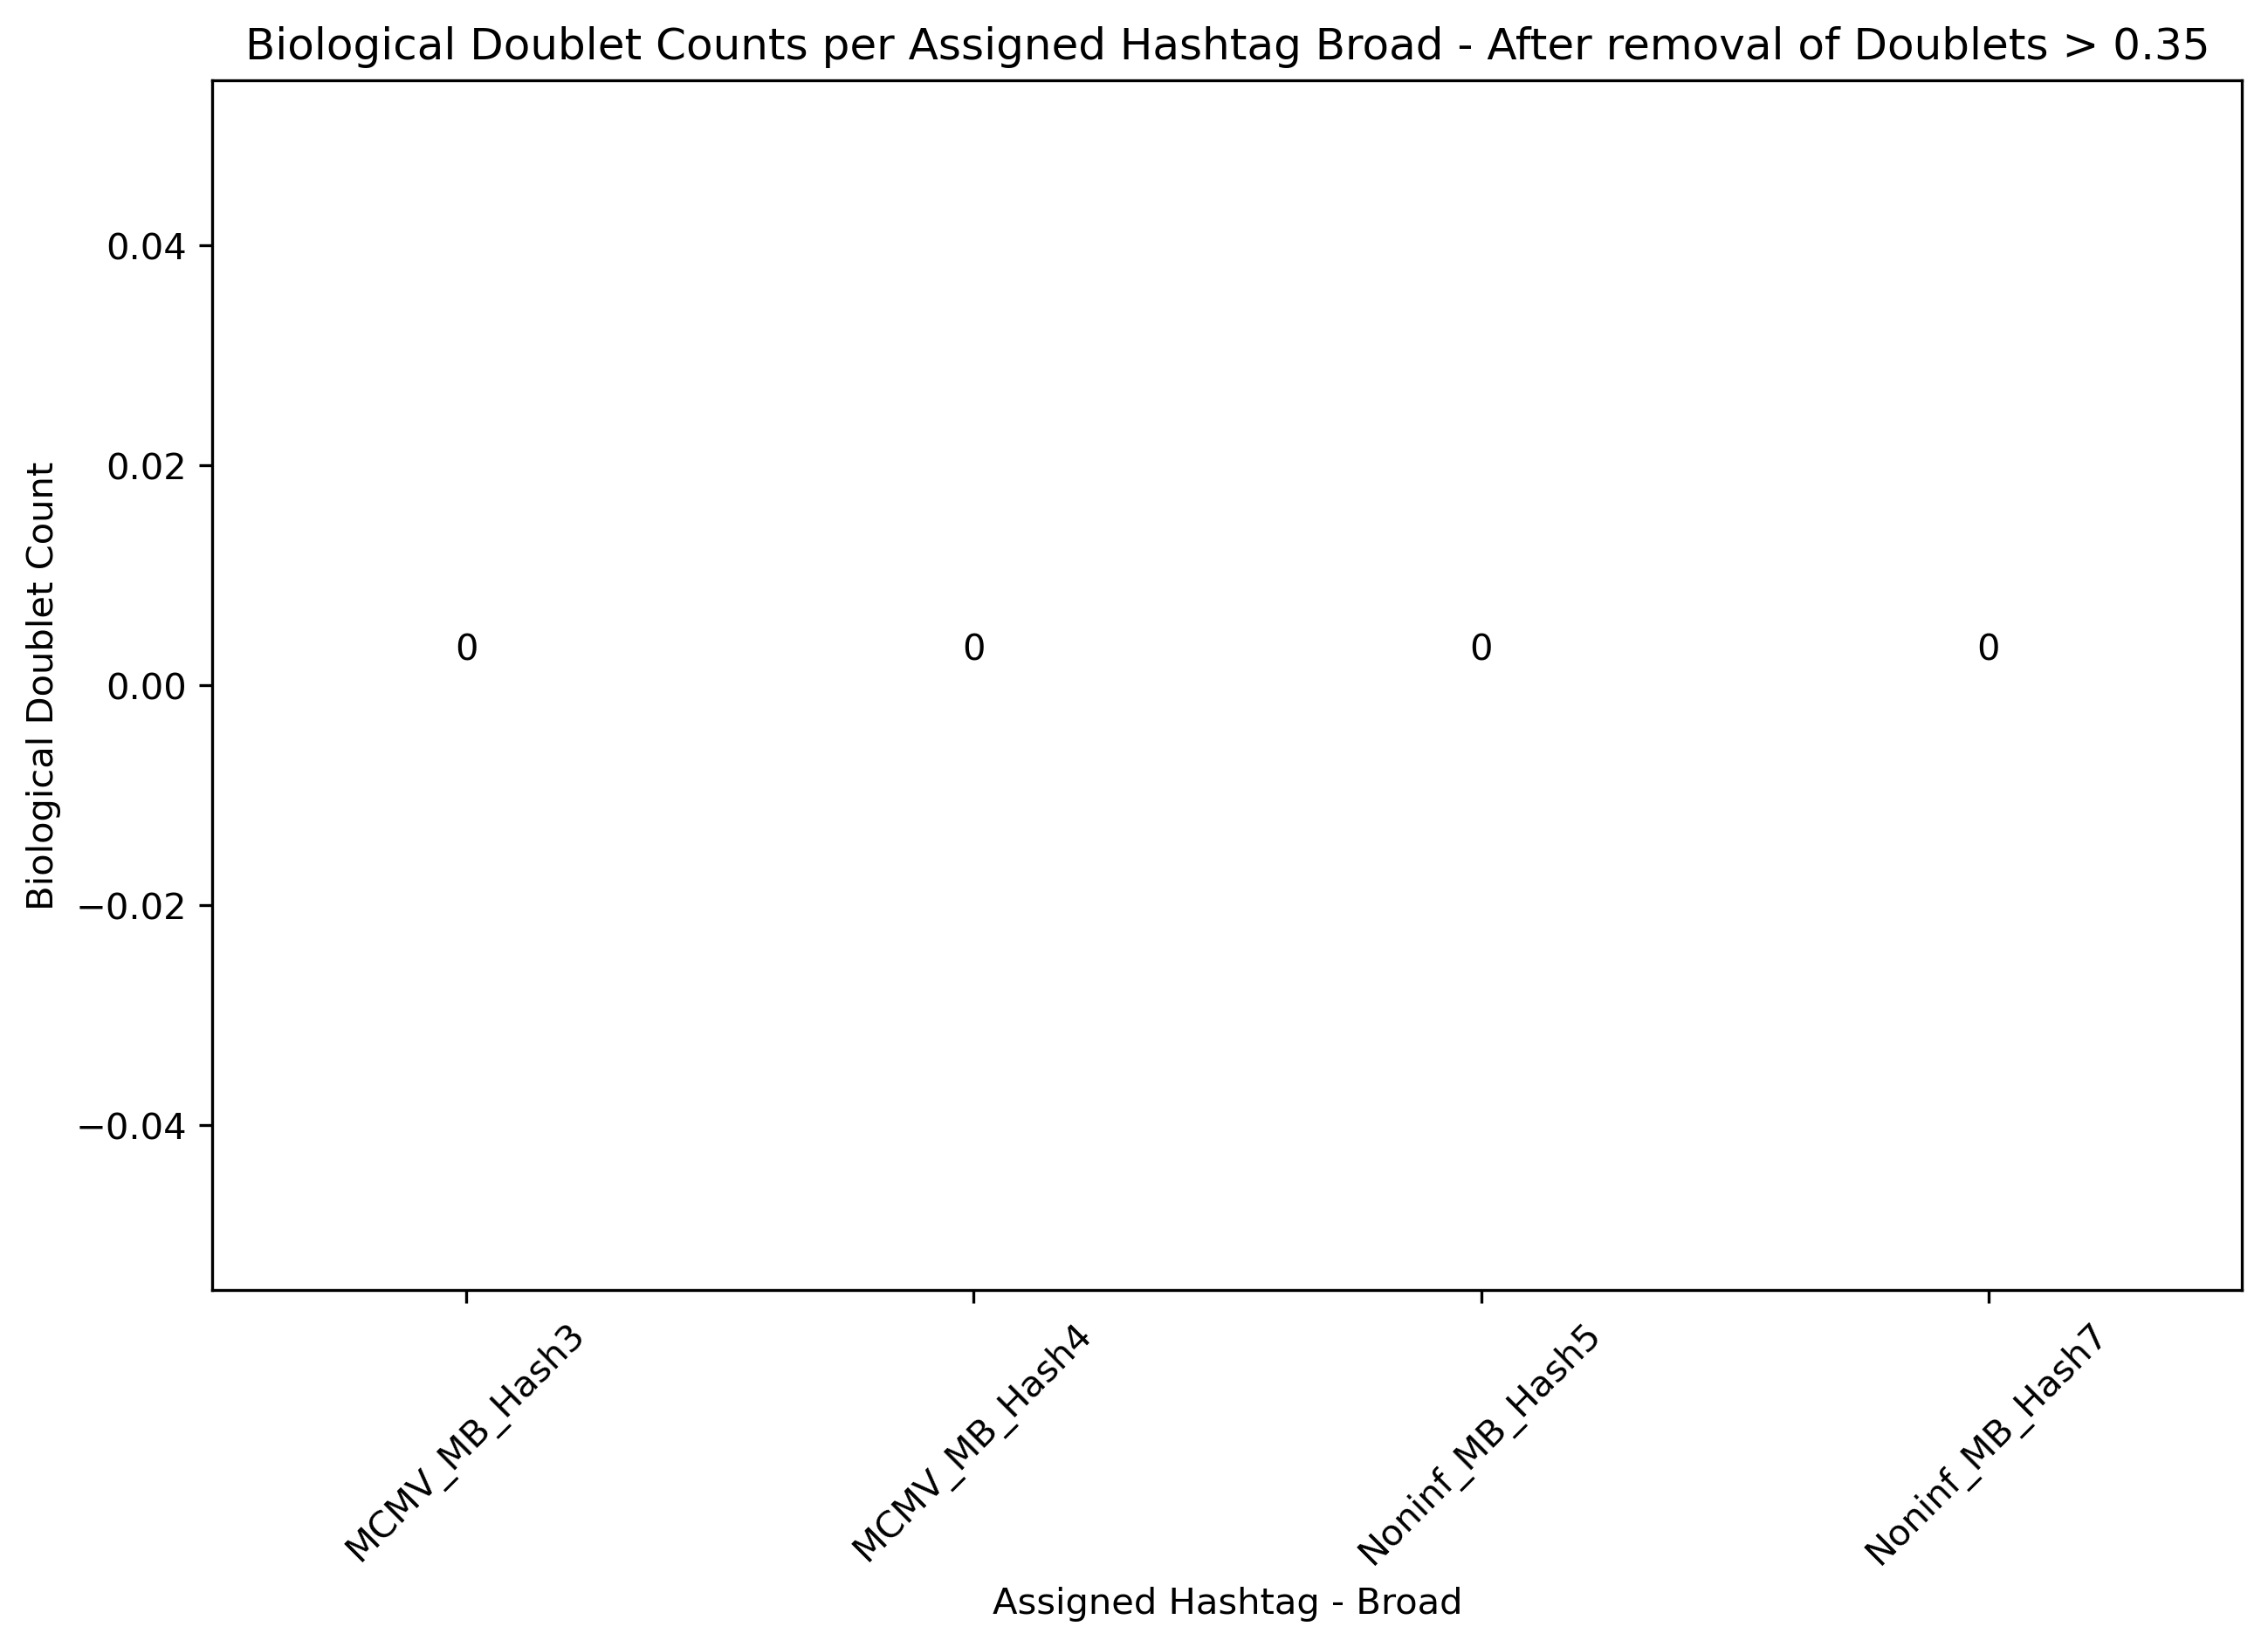

In [45]:
plt.figure(figsize=(10, 6))

ax = sb.barplot(data=doublet_counts_per_assigned_hashtag_global, x='assigned_hashtag', y='Doublet_Count', hue='assigned_hashtag')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)
plt.xlabel("Assigned Hashtag - Broad")
plt.ylabel("Biological Doublet Count")
plt.title("Biological Doublet Counts per Assigned Hashtag Broad - After removal of Doublets > 0.35")
plt.show()

# Data Export

In [46]:
filtered_object.obs['predicted_doublets'] = filtered_object.obs['predicted_doublets'].astype(int)

In [47]:
filtered_object.write_h5ad(f'./data/demultiplexed_htodemux_scrublet_doublet_removal_magnetic_beads_{timestamp}.h5ad')